**Load the necessary packages**

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from fancyimpute import KNN
from sklearn.model_selection import train_test_split
import lightgbm as lgb

import os
print(os.listdir("../input"))

Using TensorFlow backend.


['test.csv', 'train.csv', 'sample_submission.csv', 'data_description.txt']


**Import training dataset**

In [2]:
#Train data
train_df=pd.read_csv('../input/train.csv')
#Test data
test_df=pd.read_csv('../input/test.csv')
#submission file
sub_df=pd.read_csv('../input/sample_submission.csv')

**Displaying the train data**

In [3]:
#Displaying of train data
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Displaying the test data**

In [4]:
#Displaying the test data
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


**Train attributes names**

In [5]:
#Feature names
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

**Data types**

In [6]:
#Data types
train_df.dtypes.head()

Id               int64
MSSubClass       int64
MSZoning        object
LotFrontage    float64
LotArea          int64
dtype: object

**Summary of the train data**

In [7]:
#Shape of traain data
print(train_df.shape)
#Displaying summary of train data
train_df.describe()

(1460, 81)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


The train data consists of 1460 observations and 81 attributes.

**Summary of test data**

In [8]:
#Shape of test data
print(test_df.shape)
#Displaying summary of test data
test_df.describe()

(1459, 80)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


**Missing value analysis**

In [9]:
#Percentage of missing values present in train data
((train_df.isnull().sum())/1460 *100).iloc[0:10]

Id              0.000000
MSSubClass      0.000000
MSZoning        0.000000
LotFrontage    17.739726
LotArea         0.000000
Street          0.000000
Alley          93.767123
LotShape        0.000000
LandContour     0.000000
Utilities       0.000000
dtype: float64

PoolQC,Fence,MiscFeature,FireplaceQU,Alley these are attributes which are having missing values more than 30% of data and we are going to ignore those attributes. 
BsmtFinType1,BsmtFinType2,BsmtExposure,BsmtCond,BsmtQual,Electrical,MasVnrType,MasVnrArea,LotFrontage,GarageType ,GarageYrBlt,GarageFinish,GarageQual,GarageCond these are attributes which are having missing values less than 30% of data and we are going to impute the missing songs.

In [10]:
#Percentage of missing values present in test data
((test_df.isnull().sum())/1460 *100).iloc[0:10]

Id              0.000000
MSSubClass      0.000000
MSZoning        0.273973
LotFrontage    15.547945
LotArea         0.000000
Street          0.000000
Alley          92.602740
LotShape        0.000000
LandContour     0.000000
Utilities       0.136986
dtype: float64

PoolQC,Fence,MiscFeature,FireplaceQU,Alley these are attributes which are having missing values more than 30% of data and we are going to ignore those attributes. BsmtFinType1,MSZoning,BsmtFinType2,BsmtExposure,BsmtCond,BsmtQual,Electrical,MasVnrType,MasVnrArea,LotFrontage,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,Utilities,Exterior1st,Exterior2nd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,KitchenQual,Functional,GarageCars,SaleType these are attributes which are having missing values less than 30% of data and we are going to impute the missing values.

**Drop the unwanted attributes**

In [11]:
#Drop the unwanted variables
test_df.drop(['Id','PoolQC','Fence','MiscFeature','FireplaceQu','Alley'],axis=1).head()
train_df.drop(['Id','PoolQC','Fence','MiscFeature','FireplaceQu','Alley'],axis=1).head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


**Creating the catgorical and numerical train attributes dataset**

In [12]:
#train categorical attributes data
train_cat_attributes=train_df[['MSZoning','Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','MasVnrType','ExterQual','BsmtQual','BsmtExposure',
                        'BsmtFinType1','Heating','HeatingQC','CentralAir','Electrical','Functional','GarageType','GarageFinish','KitchenQual','GarageQual','PavedDrive','SaleType','SaleCondition']]

#train numeric attributes data
train_num_attributes=train_df[['LotFrontage','LotArea','OverallQual','MasVnrArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
                         'FullBath','HalfBath','BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']]

**Imputing of train categorical attributes**

In [13]:
#imputing the missing values by using Simple Imputer
imp = SimpleImputer(strategy="most_frequent")
impute_cat=imp.fit_transform(train_cat_attributes)
print(impute_cat)
train_cat_attributes=pd.DataFrame(impute_cat,columns=train_cat_attributes.columns)
train_cat_attributes.head()

[['RL' 'Pave' 'Reg' ... 'Y' 'WD' 'Normal']
 ['RL' 'Pave' 'Reg' ... 'Y' 'WD' 'Normal']
 ['RL' 'Pave' 'IR1' ... 'Y' 'WD' 'Normal']
 ...
 ['RL' 'Pave' 'Reg' ... 'Y' 'WD' 'Normal']
 ['RL' 'Pave' 'Reg' ... 'Y' 'WD' 'Normal']
 ['RL' 'Pave' 'Reg' ... 'Y' 'WD' 'Normal']]


,MSZoning,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,MasVnrType,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,Heating,HeatingQC,CentralAir,Electrical,Functional,GarageType,GarageFinish,KitchenQual,GarageQual,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,CompShg,VinylSd,BrkFace,Gd,Gd,No,GLQ,GasA,Ex,Y,SBrkr,Typ,Attchd,RFn,Gd,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,Gable,CompShg,MetalSd,None,TA,Gd,Gd,ALQ,GasA,Ex,Y,SBrkr,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,CompShg,VinylSd,BrkFace,Gd,Gd,Mn,GLQ,GasA,Ex,Y,SBrkr,Typ,Attchd,RFn,Gd,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,None,TA,TA,No,ALQ,GasA,Gd,Y,SBrkr,Typ,Detchd,Unf,Gd,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,Gable,CompShg,VinylSd,BrkFace,Gd,Gd,Av,GLQ,GasA,Ex,Y,SBrkr,Typ,Attchd,RFn,Gd,TA,Y,WD,Normal


**Imputing of train numerical attributes**

In [14]:
#imputing the missing values by using Simple Imputer
imp = SimpleImputer(strategy="mean")
impute_num=imp.fit_transform(train_num_attributes)
print(impute_num)
train_num_attributes=pd.DataFrame(impute_num,columns=train_num_attributes.columns)
train_num_attributes.head()

[[6.50000e+01 8.45000e+03 7.00000e+00 ... 0.00000e+00 0.00000e+00
  2.08500e+05]
 [8.00000e+01 9.60000e+03 6.00000e+00 ... 0.00000e+00 0.00000e+00
  1.81500e+05]
 [6.80000e+01 1.12500e+04 7.00000e+00 ... 0.00000e+00 0.00000e+00
  2.23500e+05]
 ...
 [6.60000e+01 9.04200e+03 7.00000e+00 ... 0.00000e+00 2.50000e+03
  2.66500e+05]
 [6.80000e+01 9.71700e+03 5.00000e+00 ... 0.00000e+00 0.00000e+00
  1.42125e+05]
 [7.50000e+01 9.93700e+03 5.00000e+00 ... 0.00000e+00 0.00000e+00
  1.47500e+05]]


,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
0,65.0,8450.0,7.0,196.0,706.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,8.0,0.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,208500.0
1,80.0,9600.0,6.0,0.0,978.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,6.0,1.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,181500.0
2,68.0,11250.0,7.0,162.0,486.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,6.0,1.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,223500.0
3,60.0,9550.0,7.0,0.0,216.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,7.0,1.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,140000.0
4,84.0,14260.0,8.0,350.0,655.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,9.0,1.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,250000.0


**Distribution of attributes and trends**

**Scatter plot for MSZoning and Street**

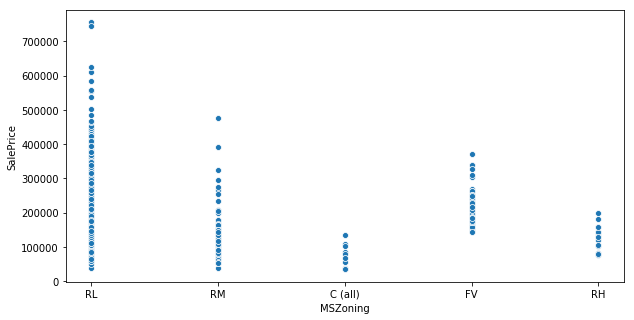

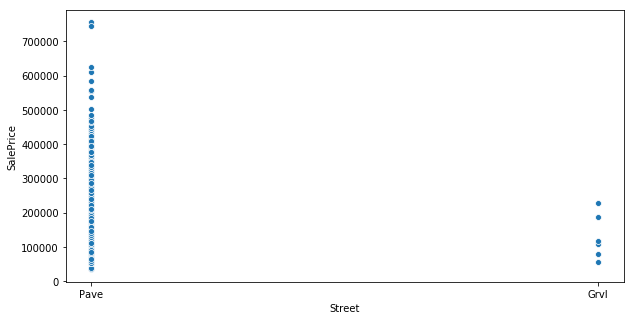

In [15]:
#Scatter plot for different zones(MSZoning)
fig=plt.figure(figsize=(10,5))
#fig,ax=plt.subplots(1,2)
sns.scatterplot(x=train_cat_attributes['MSZoning'],y=train_num_attributes['SalePrice'])

#Scatter plot for street
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_cat_attributes['Street'],y=train_num_attributes['SalePrice'])

From the above plots, we can observed that housing prices are higher at residential low density ,resedential medium density and floating village residential areas compared to residential high density and commercial areas.
Paved road access to property is higher house prices compared to Gravel road.

**Scatter plot for land contour and land configuration**

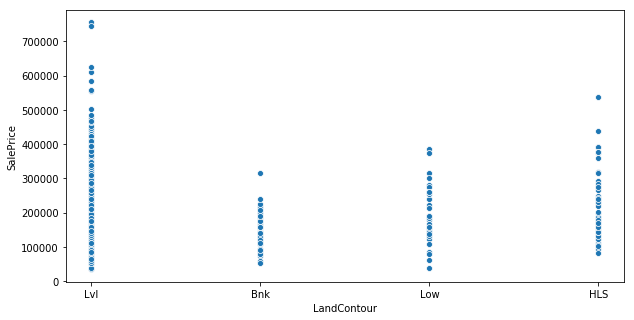

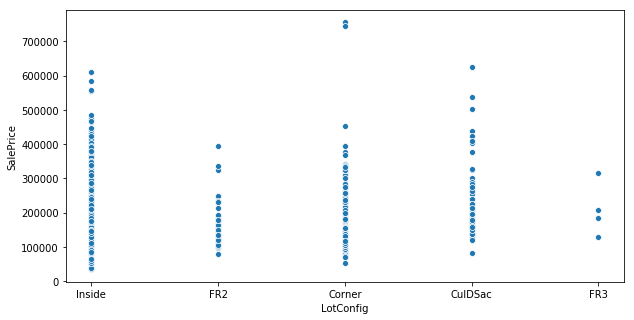

In [16]:
#Scatter plot for Land contour
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_cat_attributes['LandContour'],y=train_num_attributes['SalePrice'])

#Scatter plot for Land config
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_cat_attributes['LotConfig'],y=train_num_attributes['SalePrice'])

From the above plots, we can observed that housing prices are higher for level or flat and hillside land contour compared to banked and depression land contour and housing prices are higher for inside,corner and cul-de-sac lot confi.compared to other lot configurations.

**Scatter for lot frontage and lot area**

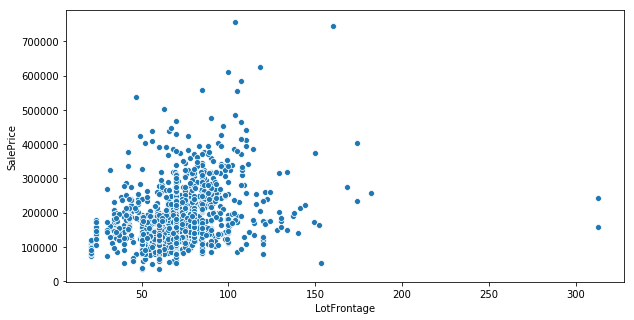

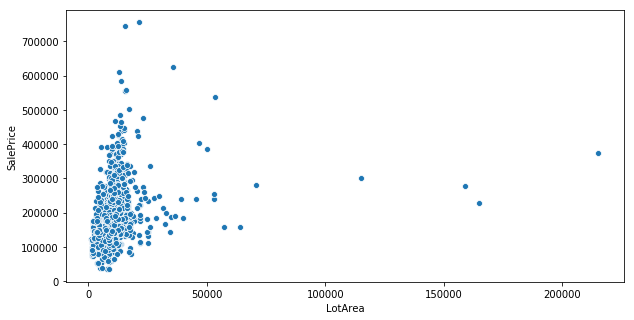

In [17]:
#Scatter plot for Land frontage
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_num_attributes['LotFrontage'],y=train_num_attributes['SalePrice'])
#Scatter plot for lot area
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_num_attributes['LotArea'],y=train_num_attributes['SalePrice'])

From the above plots, we can observed that housing price increases as increasing the lot frontage length of street connected to property and also housing price increases as increasing the lot area.

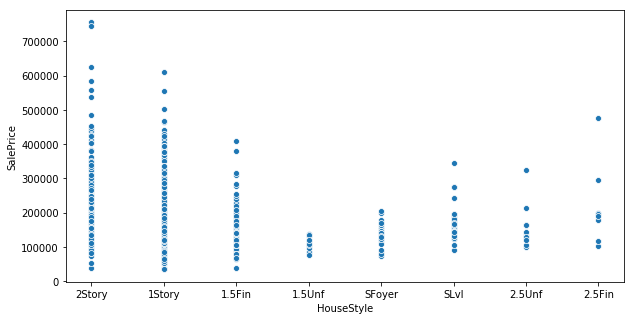

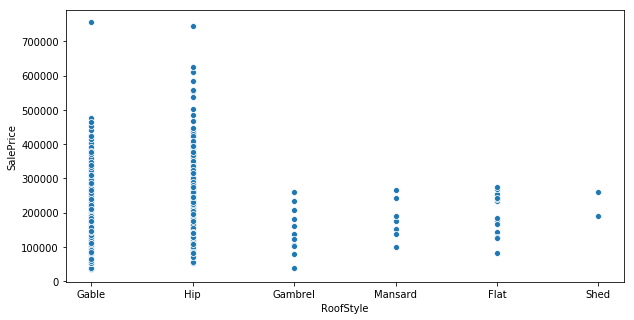

In [18]:
#Scatter plot fortype of House Style
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_cat_attributes['HouseStyle'],y=train_num_attributes['SalePrice'])

#Scatter plot for type of Roof Style
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_cat_attributes['RoofStyle'],y=train_num_attributes['SalePrice'])

From the above plots,we can observed that housing prices are higher for 2story,1story and 1.5 finished story compared to other house styles and housing prices are higher for Gable and Hip root style compared to other roof styles.

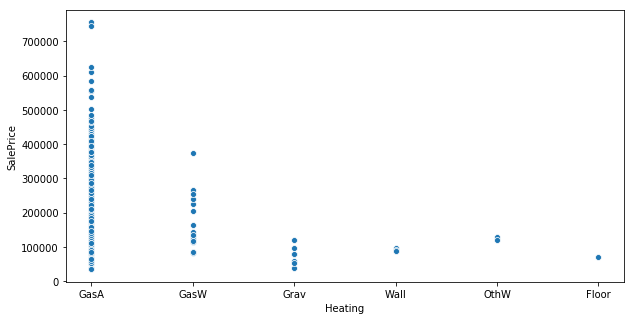

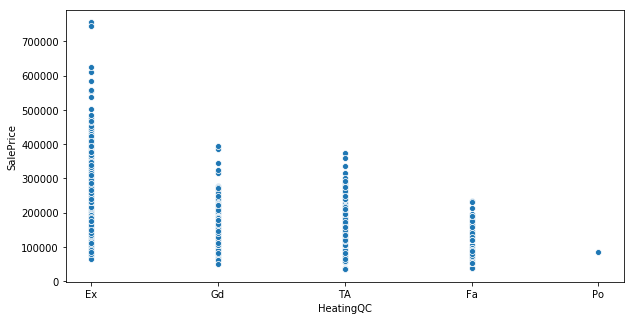

In [19]:
#Scatter plot for type of Heating
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_cat_attributes['Heating'],y=train_num_attributes['SalePrice'])

#Scatter plot for Heating Quality
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_cat_attributes['HeatingQC'],y=train_num_attributes['SalePrice'])

From the above plots, we can observed that housing prices are higher for gas hot air and gas hot water heating compared to other heating resources and housing prices are higher for Excellent and Good rate heating quality comared to other ratings. 

**Scatter plot for Electrical and Central air**

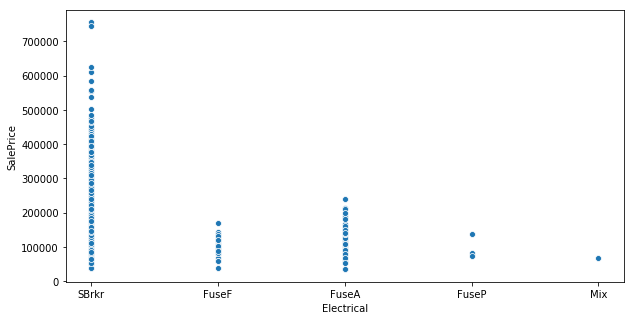

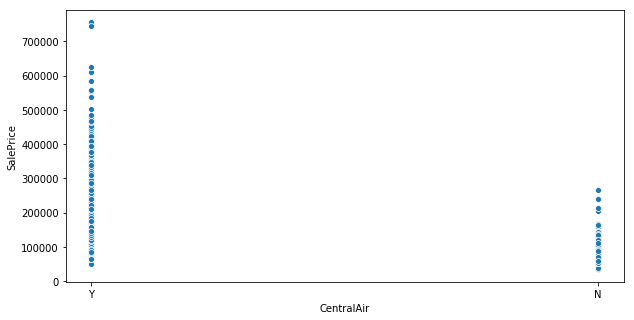

In [20]:
#Scatter plot for Electrical
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_cat_attributes['Electrical'],y=train_num_attributes['SalePrice'])

#Scatter plot for Central Air
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_cat_attributes['CentralAir'],y=train_num_attributes['SalePrice'])

From the above plots, we can observed that housing prices are higher for standard circuit breakers & romex elctrical system compared to other electrical systems and housing prices are higher for houses having central air conditioining compared to non air conditioining houses.

**Scatter plot for GarageType and KitchenQual**

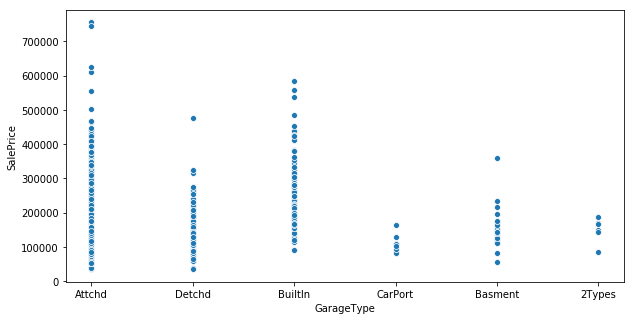

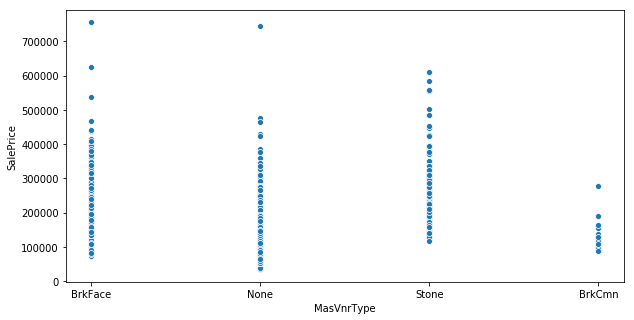

In [21]:
#Scatter plot for Garage type
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_cat_attributes['GarageType'],y=train_num_attributes['SalePrice'])
#Scatter plot for Kitchen quality
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_cat_attributes['MasVnrType'],y=train_num_attributes['SalePrice'])

From the above plots, we can observed that housing prices are higher for attached and Bullt-In garage type compared to other garage types and housing prices are higher for brick face and stone masonary veneer tye compared to other types.

**Scatter plot for Garage Cars and Garage Area**

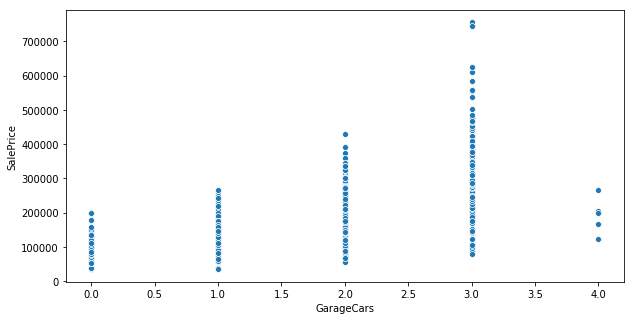

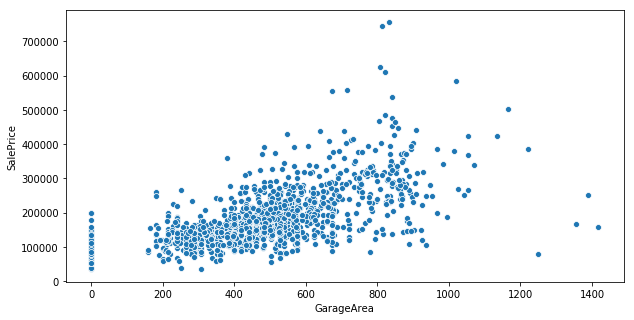

In [22]:
#Scatter plot for Garage cars
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_num_attributes['GarageCars'],y=train_num_attributes['SalePrice'])
#Scatter plot for Garage Area
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_num_attributes['GarageArea'],y=train_num_attributes['SalePrice'])

From the above plots, we can observed that housing prices are higher for 3 cars garage compared to other garage cars and housing price increases as incresing the garage area.

**Scatter plot for Sale type and Sale Condition**

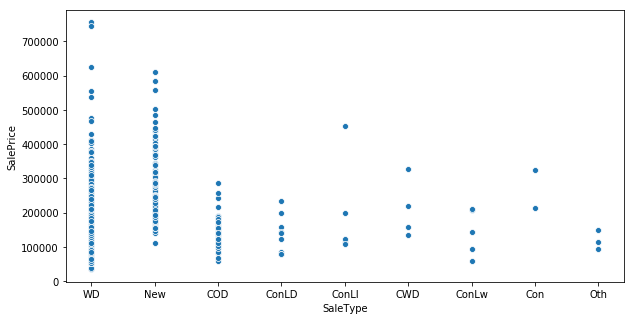

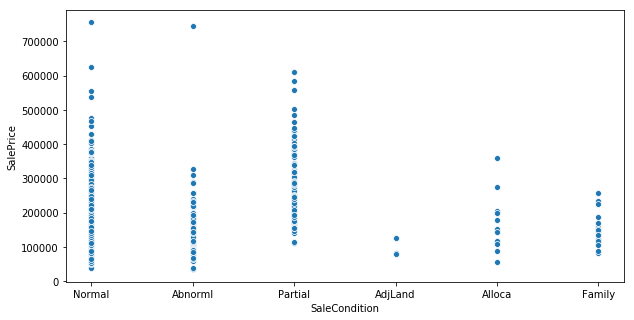

In [23]:
#Scatter plot for Sale type
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_cat_attributes['SaleType'],y=train_num_attributes['SalePrice'])
#Scatter plot for Sale condition
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_cat_attributes['SaleCondition'],y=train_num_attributes['SalePrice'])

From the above plots, we can observed that housing prices are higher for warranty deed-conventional and home just constructed and sold houses compared to other type houses and housing prices are higher for normal and partial condtion of sale compared to other sale conditions.

**Encoding train Categorical attributes**

In [24]:
#Encoding train categorical attributes
train_cat_attributes=pd.get_dummies(train_cat_attributes,columns=train_cat_attributes.columns)
train_cat_attributes.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,...,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


**Creating the catgorical and numerical test attributes**

In [25]:
#Categorical test attributes
test_cat_attributes=test_df[['MSZoning','Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','MasVnrType','ExterQual','BsmtQual','BsmtExposure',
                        'BsmtFinType1','Heating','HeatingQC','CentralAir','Electrical','Functional','GarageType','GarageFinish','KitchenQual','GarageQual','PavedDrive','SaleType','SaleCondition']]

#Numeric test attributes
test_num_attributes=test_df[['LotFrontage','LotArea','OverallQual','MasVnrArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
                         'FullBath','HalfBath','BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch', '3SsnPorch','ScreenPorch','PoolArea','MiscVal']]

**Imputing of train categorical attributes**

In [26]:
#imputing the missing values by using Simple Imputer
imp = SimpleImputer(strategy="most_frequent")
impute_cat=imp.fit_transform(test_cat_attributes)
print(impute_cat)
test_cat_attributes=pd.DataFrame(impute_cat,columns=test_cat_attributes.columns)
test_cat_attributes.head()

[['RH' 'Pave' 'Reg' ... 'Y' 'WD' 'Normal']
 ['RL' 'Pave' 'IR1' ... 'Y' 'WD' 'Normal']
 ['RL' 'Pave' 'IR1' ... 'Y' 'WD' 'Normal']
 ...
 ['RL' 'Pave' 'Reg' ... 'Y' 'WD' 'Abnorml']
 ['RL' 'Pave' 'Reg' ... 'Y' 'WD' 'Normal']
 ['RL' 'Pave' 'Reg' ... 'Y' 'WD' 'Normal']]


,MSZoning,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,MasVnrType,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,Heating,HeatingQC,CentralAir,Electrical,Functional,GarageType,GarageFinish,KitchenQual,GarageQual,PavedDrive,SaleType,SaleCondition
0,RH,Pave,Reg,Lvl,Inside,Gtl,NAmes,Feedr,1Fam,1Story,Gable,CompShg,VinylSd,None,TA,TA,No,Rec,GasA,TA,Y,SBrkr,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
1,RL,Pave,IR1,Lvl,Corner,Gtl,NAmes,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,BrkFace,TA,TA,No,ALQ,GasA,TA,Y,SBrkr,Typ,Attchd,Unf,Gd,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,Gable,CompShg,VinylSd,None,TA,Gd,No,GLQ,GasA,Gd,Y,SBrkr,Typ,Attchd,Fin,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,Gable,CompShg,VinylSd,BrkFace,TA,TA,No,GLQ,GasA,Ex,Y,SBrkr,Typ,Attchd,Fin,Gd,TA,Y,WD,Normal
4,RL,Pave,IR1,HLS,Inside,Gtl,StoneBr,Norm,TwnhsE,1Story,Gable,CompShg,HdBoard,None,Gd,Gd,No,ALQ,GasA,Ex,Y,SBrkr,Typ,Attchd,RFn,Gd,TA,Y,WD,Normal


**Imputing of test numerical attributes**

In [27]:
#imputing the missing values by using Simple Imputer
imp = SimpleImputer(strategy="mean")
impute_num=imp.fit_transform(test_num_attributes)
print(impute_num)
test_num_attributes=pd.DataFrame(impute_num,columns=test_num_attributes.columns)
test_num_attributes.head()

[[8.0000e+01 1.1622e+04 5.0000e+00 ... 1.2000e+02 0.0000e+00 0.0000e+00]
 [8.1000e+01 1.4267e+04 6.0000e+00 ... 0.0000e+00 0.0000e+00 1.2500e+04]
 [7.4000e+01 1.3830e+04 5.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [1.6000e+02 2.0000e+04 5.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [6.2000e+01 1.0441e+04 5.0000e+00 ... 0.0000e+00 0.0000e+00 7.0000e+02]
 [7.4000e+01 9.6270e+03 7.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]


,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,80.0,11622.0,5.0,0.0,468.0,270.0,882.0,896.0,0.0,0.0,896.0,0.0,0.0,1.0,0.0,2.0,5.0,0.0,1.0,730.0,140.0,0.0,0.0,0.0,120.0,0.0,0.0
1,81.0,14267.0,6.0,108.0,923.0,406.0,1329.0,1329.0,0.0,0.0,1329.0,0.0,0.0,1.0,1.0,3.0,6.0,0.0,1.0,312.0,393.0,36.0,0.0,0.0,0.0,0.0,12500.0
2,74.0,13830.0,5.0,0.0,791.0,137.0,928.0,928.0,701.0,0.0,1629.0,0.0,0.0,2.0,1.0,3.0,6.0,1.0,2.0,482.0,212.0,34.0,0.0,0.0,0.0,0.0,0.0
3,78.0,9978.0,6.0,20.0,602.0,324.0,926.0,926.0,678.0,0.0,1604.0,0.0,0.0,2.0,1.0,3.0,7.0,1.0,2.0,470.0,360.0,36.0,0.0,0.0,0.0,0.0,0.0
4,43.0,5005.0,8.0,0.0,263.0,1017.0,1280.0,1280.0,0.0,0.0,1280.0,0.0,0.0,2.0,0.0,2.0,5.0,0.0,2.0,506.0,0.0,82.0,0.0,0.0,144.0,0.0,0.0


**Encoding test Categorical attributes**

In [28]:
#Encoding test categorical attributes
test_cat_attributes=pd.get_dummies(test_cat_attributes,columns=test_cat_attributes.columns)
test_cat_attributes.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,...,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


**Merging categorical and numeric train attributes**

In [29]:
#Merging categorical and numeric train attributes
train_attributes=pd.merge(train_cat_attributes,train_num_attributes,left_index=True,right_index=True)
train_attributes.shape

(1460, 210)

**Merging categorical and numeric test attributes**

In [30]:
#Merging categorical and numeric test attributes
test_attributes=pd.merge(test_cat_attributes,test_num_attributes,left_index=True,right_index=True)
test_attributes.head()
test_attributes.shape

(1459, 198)

**Correlation Analysis for train attributes**

In [31]:
#Correlations in train attributes
attributes=train_attributes.columns.values
correlations=train_attributes[attributes].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
train_correlations=correlations[correlations['level_0']!=correlations['level_1']]
print(train_correlations.tail())

                     level_0       level_1         0
43885  SaleCondition_Partial  SaleType_New  0.986819
43957            Street_Pave   Street_Grvl  1.000000
43958            Street_Grvl   Street_Pave  1.000000
44095           CentralAir_Y  CentralAir_N  1.000000
44096           CentralAir_N  CentralAir_Y  1.000000


From the above train correlations, we can observed that some attributes are slightly correlated to each other and some are highly correlated to each other based on threshold value 0.8. Highly correlated attributes are carrying same information, so we are going to ignore one of attribute in further analysis.

**Drop the unwanted train attributes**

In [32]:
#drop the unwanted train attributes
train_attributes=train_attributes.drop(['CentralAir_Y','Street_Grvl','SaleCondition_Partial','RoofStyle_Gable','LotShape_IR1', 'LandSlope_Gtl','ExterQual_TA','GarageArea','Neighborhood_Somerst','Electrical_FuseA',
                                       'PavedDrive_N','RoofMatl_Tar&Grv','GarageQual_Fa','TotRmsAbvGrd','KitchenQual_TA','GarageType_Detchd','TotalBsmtSF','HouseStyle_2Story','MSZoning_RL','BsmtQual_TA','MasVnrType_None'],axis=1)
print(train_attributes.shape)
train_attributes.head()

(1460, 189)


,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,...,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,65.0,8450.0,7.0,196.0,706.0,150.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,0.0,2.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,208500.0
1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,80.0,9600.0,6.0,0.0,978.0,284.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,2.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,181500.0
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,68.0,11250.0,7.0,162.0,486.0,434.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,2.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,223500.0
3,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,60.0,9550.0,7.0,0.0,216.0,540.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,3.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,140000.0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,84.0,14260.0,8.0,350.0,655.0,490.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,3.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,250000.0


**Correlation Analysis for test attributes**

In [33]:
#Correlations in test attributes
attributes=test_attributes.columns.values
correlations=test_attributes[attributes].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
test_correlations=correlations[correlations['level_0']!=correlations['level_1']]
print(test_correlations.tail())

                     level_0       level_1         0
39001  SaleCondition_Partial  SaleType_New  0.986317
39069            Street_Pave   Street_Grvl  1.000000
39070            Street_Grvl   Street_Pave  1.000000
39200           CentralAir_Y  CentralAir_N  1.000000
39201           CentralAir_N  CentralAir_Y  1.000000


From the above test correlations, we can observed that some attributes are slightly correlated to each other and some are highly correlated to each other based on threshold value 0.8. Highly correlated attributes are carrying same information, so we are going to ignore one of attribute in further analysis.

**Drop the unwanted test attributes**

In [34]:
#drop the unwanted test attributes
test_attributes=test_attributes.drop(['Street_Grvl','CentralAir_N','SaleCondition_Partial','LandSlope_Gtl','RoofStyle_Gable','LotShape_IR1','GarageQual_Fa','GarageArea','ExterQual_TA','PavedDrive_N','Neighborhood_Somerst',
                     'Electrical_FuseA','RoofMatl_Tar&Grv','Heating_GasW','KitchenQual_Gd','MasVnrType_None','HouseStyle_2Story','MSZoning_RL','GarageType_Detchd'],axis=1)
print(test_attributes.shape)
test_attributes.head()

(1459, 179)


,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,...,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,80.0,11622.0,5.0,0.0,468.0,270.0,882.0,896.0,0.0,0.0,896.0,0.0,0.0,1.0,0.0,2.0,5.0,0.0,1.0,140.0,0.0,0.0,0.0,120.0,0.0,0.0
1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,81.0,14267.0,6.0,108.0,923.0,406.0,1329.0,1329.0,0.0,0.0,1329.0,0.0,0.0,1.0,1.0,3.0,6.0,0.0,1.0,393.0,36.0,0.0,0.0,0.0,0.0,12500.0
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,74.0,13830.0,5.0,0.0,791.0,137.0,928.0,928.0,701.0,0.0,1629.0,0.0,0.0,2.0,1.0,3.0,6.0,1.0,2.0,212.0,34.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,78.0,9978.0,6.0,20.0,602.0,324.0,926.0,926.0,678.0,0.0,1604.0,0.0,0.0,2.0,1.0,3.0,7.0,1.0,2.0,360.0,36.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,43.0,5005.0,8.0,0.0,263.0,1017.0,1280.0,1280.0,0.0,0.0,1280.0,0.0,0.0,2.0,0.0,2.0,5.0,0.0,2.0,0.0,82.0,0.0,0.0,144.0,0.0,0.0


**Split the train attributes data into train and validation dataset**

In [35]:
#Split the training dataset
X=train_attributes.drop(['SalePrice'],axis=1)
y=train_attributes.SalePrice
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.1)
print(X_train.shape,y_train.shape)
print(X_valid.shape,y_valid.shape)

(1314, 188) (1314,)
(146, 188) (146,)


**Setting the dataset**

In [36]:
#Setting dataset for lightgbm model
lgb_train=lgb.Dataset(X_train,label=y_train)
lgb_valid=lgb.Dataset(X_valid,label=y_valid)

**Modelling the dataset**

In [37]:
#Choosing the parameters
params={'boosting_type': 'gbdt', 
          'max_depth' : 20,
          'objective': 'regression',
          'boost_from_average':False, 
          'nthread': 8,
          'num_leaves': 120,
          'learning_rate': 0.05,
          'min_data_in_leaf':30,
          'bagging_fraction':0.8,
          'max_bin': 500,  
          'subsample_for_bin': 100,
          'metric' : 'mape',
          }

**Training the model**

In [38]:
%%time
#training the model
num_round=2000
lgbm= lgb.train(params,lgb_train,num_round,valid_sets=[lgb_train,lgb_valid],verbose_eval=100,early_stopping_rounds = 1500)
lgbm

Training until validation scores don't improve for 1500 rounds.
[100]	training's mape: 0.0643537	valid_1's mape: 0.0961107
[200]	training's mape: 0.0476756	valid_1's mape: 0.0983147
[300]	training's mape: 0.037581	valid_1's mape: 0.100366
[400]	training's mape: 0.0303879	valid_1's mape: 0.100293
[500]	training's mape: 0.0249577	valid_1's mape: 0.100587
[600]	training's mape: 0.0206887	valid_1's mape: 0.100083
[700]	training's mape: 0.0173167	valid_1's mape: 0.0993235
[800]	training's mape: 0.014933	valid_1's mape: 0.0988847
[900]	training's mape: 0.0128429	valid_1's mape: 0.0986956
[1000]	training's mape: 0.0112248	valid_1's mape: 0.0986069
[1100]	training's mape: 0.00981769	valid_1's mape: 0.098316
[1200]	training's mape: 0.00867903	valid_1's mape: 0.0980538
[1300]	training's mape: 0.00770366	valid_1's mape: 0.0979327
[1400]	training's mape: 0.00681778	valid_1's mape: 0.097647
[1500]	training's mape: 0.00606698	valid_1's mape: 0.0975659
Early stopping, best iteration is:
[96]	training

**Model performance on test data**

In [39]:
#predict the model
lgbm_predict=lgbm.predict(test_attributes,random_state=42,num_iteration=lgbm.best_iteration)
lgbm_predict

array([ 98703.59629799, 109309.413099  ,  92797.39479297, ...,
        95211.58216066,  81308.24615127,  95413.90606769])

**Plot importance features**

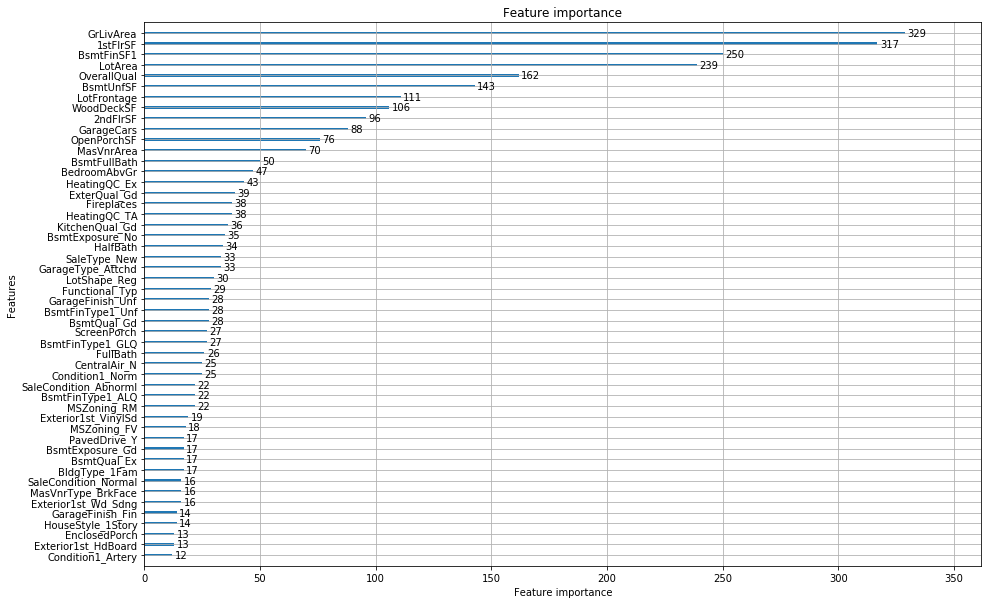

In [40]:
#plot importance features
lgb.plot_importance(lgbm,max_num_features=50,importance_type="split",figsize=(15,10))

**Submitting the prediction values**

In [41]:
df=pd.DataFrame(lgbm_predict,columns=['SalePrice'])
sub_df.append(df,sort=False)
sub_df.to_csv('House Price Predictions.csv',index=False)